In [1]:
import zipfile

with zipfile.ZipFile('drive/MyDrive/Colab Notebooks/archive.zip', 'r') as zip_ref:
    zip_ref.extractall('.')

In [2]:
import torch
import torchvision
import random
import matplotlib.pyplot as plt
from tqdm import tqdm
import numpy as np
import os

El objetivo de este cuadernillo es el de explicar si un modelo de redes neuronales convolucionales varia en la precisión de sus resultados cuando se modifica la dimensión de la imagen de manera desproporcional o se transforma una imagen a color a una monocromática

Para poder verificar si la precicion es afectada se entrenara diferentes modelos CNN en un dataset de animales y se verificara si los resultados varian de manera significativa.

In [3]:
data_transform = torchvision.transforms.Compose([
    torchvision.transforms.ToTensor()
])
dataset = torchvision.datasets.ImageFolder('raw-img', transform=data_transform)

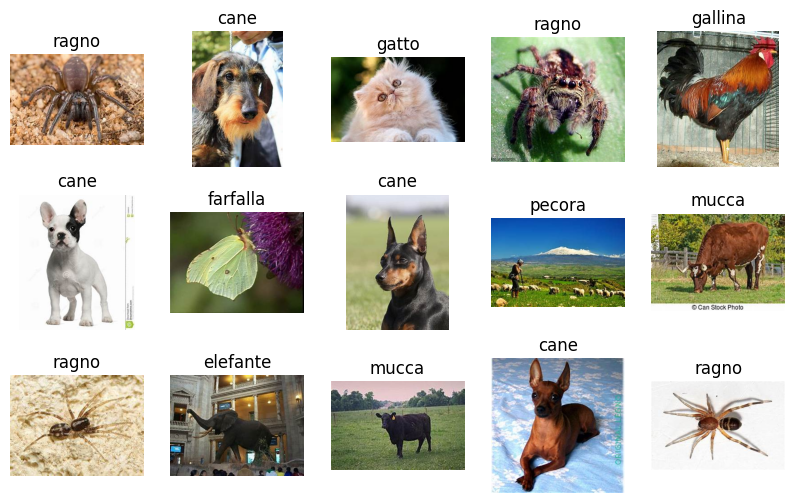

In [4]:
classes = ['cane','cavallo','elefante','farfalla','gallina','gatto','mucca','pecora','ragno','scoiattolo']
fig, axs = plt.subplots(3,5, figsize=(10,6))
for _ax in axs:
  for ax in _ax:
    ix = random.randint(0, len(dataset)-1)
    img, lab = dataset[ix]
    ax.imshow(img.permute(1,2,0))
    ax.axis('off')
    ax.set_title(classes[lab])
plt.show()

El dataset contiene imagenes con diferentes formas, seleccionare solo los que tengan una forma de 200x300, y en base a estas imagenes generare 3 dataset

1.   Sera el que contiene las imagenes originales de 200x300
2.   Sera el que contiene imagenes redimensionadas a 150x150
3.   Sera el que contengan images monocromáticas




In [5]:
dataset1 = [item for item in dataset if item[0].shape == torch.Size([3, 200, 300])]
dataset2 = [(torchvision.transforms.functional.resize(img, (150, 150)), label) for img, label in dataset1]
grayscale_transform = torchvision.transforms.Grayscale(num_output_channels=1)
dataset3 = [(grayscale_transform(img), label) for img, label in dataset2]

/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


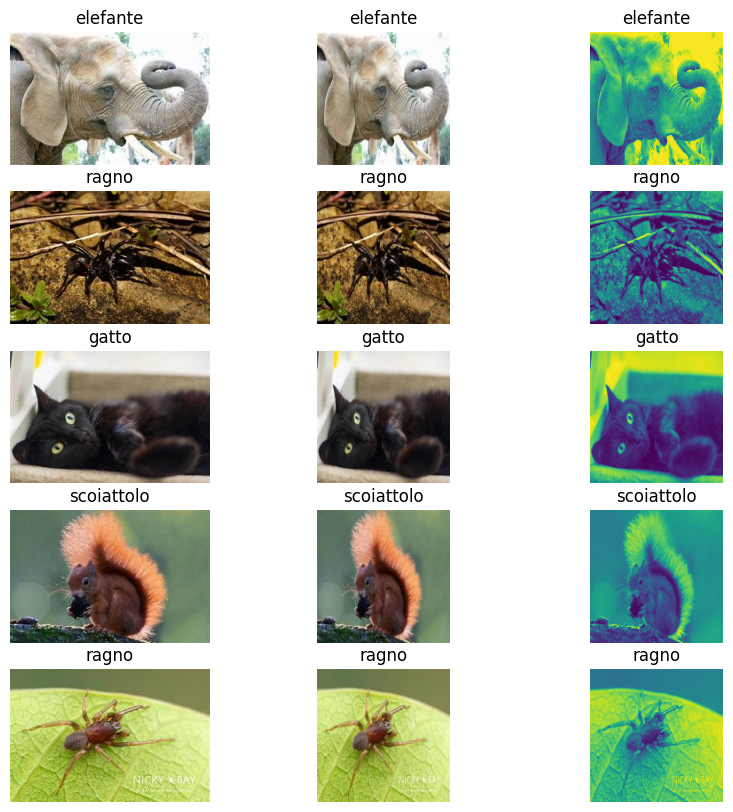

In [11]:
fig, axs = plt.subplots(5,3, figsize=(10,10))
for _ax in axs:
    ix = random.randint(0, len(dataset1)-1)
    img1, lab1 = dataset1[ix]
    img2, lab2 = dataset2[ix]
    img3, lab3 = dataset3[ix]
    # 1
    _ax[0].imshow(img1.permute(1,2,0))
    _ax[0].axis('off')
    _ax[0].set_title(classes[lab1])
    # 2
    _ax[1].imshow(img2.permute(1,2,0))
    _ax[1].axis('off')
    _ax[1].set_title(classes[lab2])
    # 3
    _ax[2].imshow(img3.permute(1,2,0))
    _ax[2].axis('off')
    _ax[2].set_title(classes[lab3])
plt.show()

In [12]:
train_size = int(0.8 * len(dataset1))
test_size = len(dataset1) - train_size
print('train size:',train_size)
print('test size:',test_size)
train_set_1, test_set_1 = torch.utils.data.random_split(dataset1, [train_size, test_size])
train_set_2, test_set_2 = torch.utils.data.random_split(dataset2, [train_size, test_size])
train_set_3, test_set_3 = torch.utils.data.random_split(dataset3, [train_size, test_size])
# Se crea dataloaders
train_loader_1 = torch.utils.data.DataLoader(train_set_1, batch_size=20, shuffle=True)
test_loader_1 = torch.utils.data.DataLoader(test_set_1, batch_size=20, shuffle=False)
train_loader_2 = torch.utils.data.DataLoader(train_set_2, batch_size=20, shuffle=True)
test_loader_2 = torch.utils.data.DataLoader(test_set_2, batch_size=20, shuffle=False)
train_loader_3 = torch.utils.data.DataLoader(train_set_3, batch_size=20, shuffle=True)
test_loader_3 = torch.utils.data.DataLoader(test_set_3, batch_size=20, shuffle=False)
dataloader1 = {
    'train': train_loader_1,
    'test': test_loader_1
}
dataloader2 = {
    'train': train_loader_2,
    'test': test_loader_2
}
dataloader3 = {
    'train': train_loader_3,
    'test': test_loader_3
}

train size: 2624
test size: 657


In [13]:
imgs, labels = next(iter(train_loader_1))
print('Forma Xi:',imgs.shape)
imgs, labels = next(iter(train_loader_2))
print('Forma Xi:',imgs.shape)
imgs, labels = next(iter(train_loader_3))
print('Forma Xi:',imgs.shape)

Forma Xi: torch.Size([20, 3, 200, 300])
Forma Xi: torch.Size([20, 3, 150, 150])
Forma Xi: torch.Size([20, 1, 150, 150])


CNN

In [14]:
class CNN(torch.nn.Module):
  def __init__(self, n_channels=1, n_outputs=10):
    super().__init__()
    self.conv1 = torch.nn.Sequential(
        torch.nn.Conv2d(in_channels=n_channels, out_channels=32, kernel_size=3, padding=1, stride=1),
        torch.nn.ReLU(),
        torch.nn.MaxPool2d(kernel_size=5, stride=5))
    self.fc2 = torch.nn.Linear(32*40*60, n_outputs)

  def forward(self, x):
    x = self.conv1(x)
    x = x.view(x.shape[0], -1)
    x = self.fc2(x)
    return x

In [15]:
def fit(model, dataloader, epochs=10, lr=1e-2):
    optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=0.01)
    criterion = torch.nn.CrossEntropyLoss()
    for epoch in range(1, epochs+1):
        model.train()
        train_loss, train_acc = [], []
        bar = tqdm(dataloader['train'])
        for batch in bar:
            X, y = batch
            X, y = X.cuda(), y.cuda()
            optimizer.zero_grad()
            y_hat = model(X)
            loss = criterion(y_hat, y)
            loss.backward()
            optimizer.step()
            train_loss.append(loss.item())
            acc = (y == torch.argmax(y_hat, axis=1)).sum().item() / len(y)
            train_acc.append(acc)
            bar.set_description(f"loss {np.mean(train_loss):.5f} acc {np.mean(train_acc):.5f}")
        bar = tqdm(dataloader['test'])
        val_loss, val_acc = [], []
        model.eval()
        with torch.no_grad():
            for batch in bar:
                X, y = batch
                X, y = X.cuda(), y.cuda()
                y_hat = model(X)
                loss = criterion(y_hat, y)
                val_loss.append(loss.item())
                acc = (y == torch.argmax(y_hat, axis=1)).sum().item() / len(y)
                val_acc.append(acc)
                bar.set_description(f"val_loss {np.mean(val_loss):.5f} val_acc {np.mean(val_acc):.5f}")
        print(f"\nEpoch {epoch}/{epochs} loss {np.mean(train_loss):.5f} val_loss {np.mean(val_loss):.5f} acc {np.mean(train_acc):.5f} val_acc {np.mean(val_acc):.5f}")

Modelo 1

In [16]:
model = CNN(n_channels=3).cuda()
fit(model, dataloader1)

val_loss 2.13058 val_acc 0.27308: 100%|██████████| 33/33 [00:00<00:00, 69.81it/s]



Epoch 1/10 loss 3.54464 val_loss 2.13058 acc 0.23674 val_acc 0.27308


val_loss 2.13250 val_acc 0.26551: 100%|██████████| 33/33 [00:00<00:00, 73.29it/s]



Epoch 2/10 loss 2.19246 val_loss 2.13250 acc 0.25379 val_acc 0.26551


val_loss 2.12639 val_acc 0.26551: 100%|██████████| 33/33 [00:00<00:00, 66.52it/s]



Epoch 3/10 loss 2.13141 val_loss 2.12639 acc 0.25417 val_acc 0.26551


val_loss 2.11587 val_acc 0.27308: 100%|██████████| 33/33 [00:00<00:00, 72.01it/s]



Epoch 4/10 loss 2.13601 val_loss 2.11587 acc 0.25303 val_acc 0.27308


val_loss 2.12703 val_acc 0.27308: 100%|██████████| 33/33 [00:00<00:00, 72.66it/s]



Epoch 5/10 loss 2.13383 val_loss 2.12703 acc 0.25455 val_acc 0.27308


val_loss 2.11583 val_acc 0.27308: 100%|██████████| 33/33 [00:00<00:00, 74.28it/s]



Epoch 6/10 loss 2.14008 val_loss 2.11583 acc 0.25492 val_acc 0.27308


val_loss 2.11779 val_acc 0.27308: 100%|██████████| 33/33 [00:00<00:00, 72.68it/s]



Epoch 7/10 loss 2.13675 val_loss 2.11779 acc 0.25492 val_acc 0.27308


val_loss 2.11827 val_acc 0.27308: 100%|██████████| 33/33 [00:00<00:00, 62.43it/s]



Epoch 8/10 loss 2.13760 val_loss 2.11827 acc 0.25303 val_acc 0.27308


val_loss 2.11747 val_acc 0.27157: 100%|██████████| 33/33 [00:00<00:00, 71.96it/s]



Epoch 9/10 loss 2.14139 val_loss 2.11747 acc 0.25341 val_acc 0.27157


val_loss 2.12639 val_acc 0.27157: 100%|██████████| 33/33 [00:00<00:00, 74.76it/s]


Epoch 10/10 loss 2.13673 val_loss 2.12639 acc 0.25303 val_acc 0.27157


Modelo 2

In [ ]:
model = CNN(n_channels=3).cuda()
fit(model, dataloader2)

val_loss 2.09468 val_acc 0.29251: 100%|██████████| 33/33 [00:00<00:00, 284.82it/s]



Epoch 1/10 loss 2.24879 val_loss 2.09468 acc 0.22348 val_acc 0.29251


val_loss 1.91516 val_acc 0.32255: 100%|██████████| 33/33 [00:00<00:00, 250.75it/s]



Epoch 2/10 loss 2.06971 val_loss 1.91516 acc 0.28258 val_acc 0.32255


val_loss 1.83407 val_acc 0.39055: 100%|██████████| 33/33 [00:00<00:00, 309.09it/s]



Epoch 3/10 loss 1.94148 val_loss 1.83407 acc 0.31856 val_acc 0.39055


val_loss 1.88060 val_acc 0.35490: 100%|██████████| 33/33 [00:00<00:00, 294.11it/s]



Epoch 4/10 loss 1.88793 val_loss 1.88060 acc 0.35341 val_acc 0.35490


val_loss 1.91080 val_acc 0.34528: 100%|██████████| 33/33 [00:00<00:00, 311.12it/s]



Epoch 5/10 loss 1.86730 val_loss 1.91080 acc 0.35379 val_acc 0.34528


val_loss 1.81537 val_acc 0.39688: 100%|██████████| 33/33 [00:00<00:00, 335.40it/s]



Epoch 6/10 loss 1.85791 val_loss 1.81537 acc 0.34886 val_acc 0.39688


val_loss 1.80405 val_acc 0.40820: 100%|██████████| 33/33 [00:00<00:00, 314.42it/s]



Epoch 7/10 loss 1.83324 val_loss 1.80405 acc 0.36288 val_acc 0.40820


val_loss 1.77414 val_acc 0.39786: 100%|██████████| 33/33 [00:00<00:00, 261.62it/s]



Epoch 8/10 loss 1.80776 val_loss 1.77414 acc 0.38598 val_acc 0.39786


val_loss 1.76192 val_acc 0.41426: 100%|██████████| 33/33 [00:00<00:00, 306.08it/s]



Epoch 9/10 loss 1.78663 val_loss 1.76192 acc 0.38371 val_acc 0.41426


val_loss 1.73663 val_acc 0.42540: 100%|██████████| 33/33 [00:00<00:00, 292.29it/s]


Epoch 10/10 loss 1.76168 val_loss 1.73663 acc 0.39924 val_acc 0.42540


Modelo 3

In [ ]:
model = CNN(n_channels=1).cuda()
fit(model, dataloader3)

val_loss 2.12708 val_acc 0.26471: 100%|██████████| 33/33 [00:00<00:00, 320.56it/s]



Epoch 1/10 loss 2.29374 val_loss 2.12708 acc 0.24545 val_acc 0.26471


val_loss 1.94060 val_acc 0.31070: 100%|██████████| 33/33 [00:00<00:00, 318.72it/s]



Epoch 2/10 loss 1.99795 val_loss 1.94060 acc 0.29886 val_acc 0.31070


val_loss 1.97223 val_acc 0.31979: 100%|██████████| 33/33 [00:00<00:00, 302.77it/s]



Epoch 3/10 loss 1.91296 val_loss 1.97223 acc 0.35455 val_acc 0.31979


val_loss 1.89505 val_acc 0.38494: 100%|██████████| 33/33 [00:00<00:00, 285.23it/s]



Epoch 4/10 loss 1.87545 val_loss 1.89505 acc 0.36136 val_acc 0.38494


val_loss 1.88018 val_acc 0.37611: 100%|██████████| 33/33 [00:00<00:00, 343.93it/s]



Epoch 5/10 loss 1.83125 val_loss 1.88018 acc 0.38750 val_acc 0.37611


val_loss 1.89698 val_acc 0.38137: 100%|██████████| 33/33 [00:00<00:00, 366.87it/s]



Epoch 6/10 loss 1.78272 val_loss 1.89698 acc 0.38788 val_acc 0.38137


val_loss 1.86440 val_acc 0.35615: 100%|██████████| 33/33 [00:00<00:00, 280.47it/s]



Epoch 7/10 loss 1.75613 val_loss 1.86440 acc 0.41629 val_acc 0.35615


val_loss 1.82996 val_acc 0.42888: 100%|██████████| 33/33 [00:00<00:00, 292.46it/s]



Epoch 8/10 loss 1.71949 val_loss 1.82996 acc 0.42879 val_acc 0.42888


val_loss 1.82410 val_acc 0.39554: 100%|██████████| 33/33 [00:00<00:00, 284.05it/s]



Epoch 9/10 loss 1.69278 val_loss 1.82410 acc 0.45833 val_acc 0.39554


val_loss 1.80244 val_acc 0.43699: 100%|██████████| 33/33 [00:00<00:00, 318.21it/s]


Epoch 10/10 loss 1.67353 val_loss 1.80244 acc 0.45152 val_acc 0.43699




*   Cambiar la dimensión de una imagen de manera desproporcional puede distorsionar la relación entre los objetos y las características en la imagen, las CNNs están diseñadas para aprender patrones y características locales en imágenes, como bordes, texturas y formas. Cuando se cambia la relación de aspecto de una imagen de manera desproporcional, estas características pueden distorsionarse y dificultar la capacidad del modelo para reconocer objetos.
*   Las CNNs, entrenadas en imágenes a todo color, dependen de la información contenida en los canales de color (rojo, verde y azul) para detectar características y estructuras visuales. Cuando se convierte una imagen a escala de grises, se pierde toda esta información de color.



Sin embargo la redimensión de imágenes en el contexto de entrenamiento de redes neuronales convolucionales (CNN) se realiza con frecuencia por varias razones, a pesar de que puede implicar la pérdida de información.



*   Compatibilidad con la arquitectura de la red
*   Eficiencia computacional
*   Reducción de la complejidad del modelo
*   Generalización y transferencia de aprendizaje

